In [1]:
## 라이브러리 로딩

import pandas as pd # 판다스 
import numpy as np # 넘파이
import time, datetime
from datetime import datetime
import csv # 파일로 저장하기 위한 툴

import ast # Abstrac Syntex Tree - 스트링 처리된 리스트를 리스트로 다시 리턴할때

# TQDM 툴
from tqdm import tqdm, trange
from tqdm import tqdm_notebook
from time import sleep

In [2]:
# 토픽 모델링 관련 라이브러리 로딩
import gensim 
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import LdaMulticore
from gensim import corpora, models, similarities

# 시각화 라이브러리
from pprint import pprint
import pyLDAvis
from pyLDAvis import gensim

In [3]:
# 토크나이징 라이브러리
import MeCab
m = MeCab.Tagger('-d /usr/local/lib/mecab/dic/mecab-ko-dic')
from konlpy.tag import Mecab
mecab = Mecab()

In [4]:
df_inven = pd.read_csv("pre_invenData.csv", encoding = 'utf8', engine='python')

In [5]:
df_battle = pd.read_csv("pre_battleData.csv", encoding = 'utf8', engine='python')

In [6]:
df_battle.head()

,Unnamed: 0,link_id,new_datetime,contents_all,Year,Month,Day
0,0,4567016695,2018-09-08 16:22:00,ㅈ같은 매칭좀 어캐좀 해봐요 왜 내가 잘해도 ㅈ같이못하는 새키들때문에 게임을 져야...,2018,9,8
1,1,4567026707,2018-09-08 15:13:00,아나 스킨관련 신 스킨 살무사 아나 수면총 색 고정말고 스킨 색 대로 해...,2018,9,8
2,2,4567036673,2018-09-07 13:58:00,인팟 승률 집착매칭 밸런스 파괴 빠대무간지옥 승률 만든다고 조...,2018,9,7
3,3,4567026700,2018-09-08 09:06:00,영웅리그 매칭에서 대만인들 대만인 새끼들좀 매칭 안되게 해라 말도 안통하는 머저리...,2018,9,8
4,4,4567046681,2018-09-08 07:09:00,신영웅 그만만들고 기존영웅 손좀보시죠 신영웅 이제 그만좀만드시고요 기존영웅 ...,2018,9,8


In [7]:
df_inven.head()

,Unnamed: 0,link_id,new_datetime,contents_all,Year,Month,Day
0,0,1214270,2018-08-30 16:06:00,댓글 차단 가 적용됩니다 안녕하세요 인벤 커뮤니티팀입니다 인벤을 이용하다 보면...,2018,8,30
1,1,1214678,2018-09-05 11:56:00,월 주차 히어로즈 인벤 주간 이벤트 당첨자 발표 안녕하세요 히어로즈 오브 더 ...,2018,9,5
2,2,1214899,2018-09-06 22:38:00,오시공 김정민 문규리 침착맨 네클릿 옥냥이 메피스토 특별방송,2018,9,6
3,3,1215180,2018-09-10 23:57:00,ㅋㅋㅋㅋ 장구벌레,2018,9,10
4,4,1215179,2018-09-10 23:52:00,캘타스 뭐가 더 비슷한가요 타겜이지만 ㅎ 고민,2018,9,10


In [8]:
df_battle.drop('Unnamed: 0', axis=1,inplace=True)
df_inven.drop('Unnamed: 0', axis=1,inplace=True)

In [9]:
df = pd.concat([df_battle, df_inven])

In [10]:
## 이전 자료 드랍 전 갯수

len(df)

153073

In [11]:
## 분기별 분석을 위해 2017년 8월 이전의 데이터 + 2018년 9월 이후 데이터를 지움
## 인덱스 리셋

df['new_datetime'] = df['new_datetime'].apply(pd.to_datetime)

df = df.drop(df[(df.Year<=2016)].index)
df = df.drop(df[(df.Year==2017) & (df.Month<=8)].index)
df = df.drop(df[(df.Year==2018) & (df.Month==9)].index)

df.reset_index(drop=True, inplace=True)

In [12]:
## 지운 이후 문서 갯수

len(df)

147495

In [13]:
df.head()

,link_id,new_datetime,contents_all,Year,Month,Day
0,4566586791,2018-06-27 07:51:00,매칭시스템 문의 다인큐랑 고랩좀 그만만나자,2018,6,27
1,4566556757,2018-06-26 14:21:00,개인등급조절점수 개인등급조절점수 이거 도대체 기준이 뭔가요 연승으로 이기고있...,2018,6,26
2,4566576794,2018-06-26 14:17:00,그래픽 최적화 좀 하세요 램 겁나먹지 별로 좋지도 않으면서 사양만 엄청타고 ㅡㅡ,2018,6,26
3,4566566773,2018-06-26 07:43:00,요즘 히오스 끊김 현상 이번 패치 이후로 계속 끊김 현상이 발생합니다 패치이후로 ...,2018,6,26
4,4566586775,2018-06-26 06:10:00,매칭 시스템 우리는 노탱 상대는 그래도 자리야라는 쉴드탱 킬각 재고싶어도 ...,2018,6,26


In [14]:
%%time

tokens_all = []

for i in list(df["contents_all"]):
    k = mecab.nouns(i)
    tokens = []    
    for j in range(len(k)):
        if len(k[j]) > 1:
            tokens.append(k[j])
        else:
            continue
    tokens_all.append(tokens)
    
print(tokens_all[:10])

[['매칭', '시스템', '다인'], ['개인', '등급', '조절', '점수', '개인', '등급', '조절', '점수', '이거', '기준', '뭔가요', '연승', '개인', '등급', '조절', '점수', '때문', '언저리', '게임', '등급', '려고', '급전', '건데', '발목', '시스템', '가요'], ['그래픽', '최적', '사양'], ['히오스', '현상', '이번', '패치', '이후', '현상', '발생', '패치', '이후', '정도', '현상', '발생', '접속', '인터넷', '유선', '사용', '현상', '발생'], ['매칭', '시스템', '우리', '상대', '자리야', '쉴드', '자리', '보호막', '게임'], ['욕설', '침묵', '사유', '최근', '욕설', '침묵', '주일', '고객', '지원', '문의', '사유', '정지', '평소', '트롤링', '사람', '비아', '주일', '정지', '동안', '플레이', '사유', '메일', '확인', '내용', '채팅', '노력', '신고', '누적', '정지', '단어', '문제', '채팅', '전체', '문제', '유일', '기준', '신고', '누적'], ['탈주자', '패널', '개인', '사정', '탈주', '개소리', '이유', '나머지', '건데', '그걸', '개인', '사정', '나머지', '팀원', '자기', '탈주', '패널', '불만', '애초', '상황'], ['욕설', '정지', '로켓', '자폭', '논리', '가임', '문제', '경험', '레이너', '혼자', '케리건', '와나', '정신병자', '정신병자', '미안', '전적', '신데', '전적', '부캐', '브론즈', '미안', '루나라', '동안', '대류', '사람', '저건', '신고', '실력', '제재', '이유', '채팅', '내역', '일부', '인정', '채팅', '내역', '제재', '사유', '로켓', '자폭', '정크', '이름', '신고', 

In [15]:
tokens_df = pd.DataFrame({"tokens":tokens_all})

In [16]:
# 불용어 제거 함수 정의

### 임의로 제거한 단어 : 히어로즈, 오브, 스톰, 인벤, 하나, 시공, 히오스

def remove_stopwords(text):
    stops = ['같은', '건가요', '겁니다', '것은', '건데', '것입니다','결국','경우','그것','그렇', '그게',
             '그러나', '그런', '그리고', '년도', '대한', '때문', '많은', '말하', '못하', '뭔가',
             '본인', '사실', '생각', '서로', '이거', '이게', '아니', '아무', '어디', '어떤', '언제', '없는', '없습니다',
             '여기', '여러분', '예전', '오늘', '우리', '위한', '위해', '이게', '이런', '이번', '이후,'
             '있는', '있습니다', '자신', '저거', '저번', '정도', '하고', '하는','한다','합니다',
            '누가', '이건', '자체', '건지', '대신', '지금', '그때', '만약', '무엇', '요즘', '완전',
            '녀석', '옛날', '얼마', '뭔가요', '근대', '안녕', '요새', '저기', '나중', '걸로', '이걸','그걸', '당시',
            '건가', '이제', '저건', '보통', '당신', '은근', '등등', '누구', '인데', '당장', '이때', '거기', '여긴',
            '저희', '대체','저게', '뭔지','맞음', '따위', '그거', '그건', '가요', '누군가', '진짜', '이것', '히오스',
            '걸까', '만큼', '게임', '부분', '가지', '자기', '걸까요', '듯이', '까지', '텐데', '동안', '나름', '아래',' 느낌', '그동안'
            '히어로즈','오브','스톰','제게', '과연', '사람', '인벤', '하나', '시공', '신데','보임','조지','뭔데','답니다',
            '한동안','어마','엊그제', '애시당초','지게','추창','대부분','겁니까','겁니다','이외','조금','영웅']
    
    # Stopwords 불용어 제거
    meaningful_words = [w for w in text if not w in stops]
    meaningful_list =  ''.join(str(meaningful_words))
    return ast.literal_eval(meaningful_list)

In [17]:
### 토픽 모델링에 적용할 리스트에 대한 단어들 처리
### TFIDF를 굳이 적용할 필요는 없어보인다. 문장에 하나의 단어만 존재하도록 전처리를 한다.

total = tqdm_notebook(range(147495))

unique_list = []

for i in total:
    unique_a = tokens_df.loc[i][0]
    unique_b = set(unique_a)
    unique_c = list(unique_b)
    unique_list.append(unique_c)

In [18]:
## 토픽 모델링에 적용할 단어들 처리

total = tqdm_notebook(range(147495))

for i in total:
    unique_list[i] = remove_stopwords(unique_list[i])

In [19]:
## unique list를 잘 만들었는지 확인한다.

len(unique_list)

147495

In [20]:
df["tokens_contents"] = unique_list

In [21]:
df["tokens_contents"].head(10)

0                                        [매칭, 시스템, 다인]
1       [기준, 급전, 려고, 연승, 발목, 등급, 시스템, 조절, 언저리, 점수, 개인]
2                                        [그래픽, 사양, 최적]
3                    [발생, 사용, 접속, 현상, 패치, 유선, 인터넷, 이후]
4                      [보호막, 시스템, 자리, 상대, 매칭, 쉴드, 자리야]
5    [문제, 지원, 플레이, 유일, 사유, 확인, 누적, 내용, 신고, 비아, 침묵, ...
6    [패널, 이유, 불만, 개소리, 애초, 상황, 나머지, 팀원, 탈주, 사정, 개인,...
7    [케리건, 문제, 이유, 인정, 병신, 채금, 로켓, 내역, 사유, 정크, 무사, ...
8                           [모회사, 난투, 번역, 시스템, 적진, 매칭]
9    [이유, 문제, 리스크, 전사, 이근대, 생비, 바닥, 탱커, 아서스, 패시브, 체...
Name: tokens_contents, dtype: object

In [22]:
id2word = corpora.Dictionary(df["tokens_contents"])

In [23]:
texts = df["tokens_contents"]

In [24]:
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1])

[[(0, 1), (1, 1), (2, 1)]]


In [25]:
id2word[0]

'매칭'

In [26]:
# Human readable format of corpus (term-frequency)

%time [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

CPU times: user 17 µs, sys: 0 ns, total: 17 µs
Wall time: 21 µs


[[('매칭', 1), ('시스템', 1), ('다인', 1)]]

In [27]:
print('Number of unique tokens: %d' % len(id2word))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 41062
Number of documents: 147495


## LDA

alpha = 50/T, beta= 0.1이 최상의 퍼포먼스를 낸다는 결과 (Finding scientific topics 참고)

### 참고: lda model 20

In [28]:
# Build LDA model - 처음에는 몇 개의 토픽이 있을지 예상하지 못하므로 임의로 연구자가 잡는다.

%time lda_model_20 = LdaMulticore(corpus=corpus, id2word=id2word, workers=3, num_topics=20, random_state=100, \
                                                  chunksize=100,\
                                                  passes=10, \
                                                  per_word_topics=True)

CPU times: user 28min 34s, sys: 20min 13s, total: 48min 48s
Wall time: 46min 9s


In [29]:
### 20개 모델 저장하기

lda_model_20.save('lda_model_topic20')

In [ ]:
#lda_20 = models.LdaModel.load("lda_model_topic20")

In [30]:
pprint(lda_model_20.print_topics())
doc_lda = lda_model_20[corpus]

[(0,
  '0.025*"기억" + 0.023*"메타" + 0.018*"사이" + 0.017*"모랄레스" + 0.015*"현실" + '
  '0.013*"감사" + 0.013*"사냥" + 0.013*"중간" + 0.012*"전장" + 0.012*"나라"'),
 (1,
  '0.097*"스킨" + 0.025*"상자" + 0.023*"출시" + 0.021*"와우" + 0.019*"전설" + 0.017*"스타" '
  '+ 0.016*"아서스" + 0.015*"탈것" + 0.015*"파편" + 0.013*"오버워치"'),
 (2,
  '0.063*"모랄" + 0.024*"초갈" + 0.022*"싸움" + 0.021*"정화" + 0.019*"케리건" + '
  '0.016*"자리" + 0.016*"타이밍" + 0.016*"거강" + 0.016*"서브" + 0.013*"이펙트"'),
 (3,
  '0.032*"스킬" + 0.023*"평타" + 0.021*"특성" + 0.019*"바리안" + 0.016*"체력" + '
  '0.016*"가능" + 0.015*"사거리" + 0.015*"증가" + 0.014*"기술" + 0.013*"공격"'),
 (4,
  '0.028*"경기" + 0.020*"개인" + 0.014*"선수" + 0.013*"존재" + 0.013*"개발" + 0.011*"평가" '
  '+ 0.011*"모습" + 0.010*"동네" + 0.010*"결과" + 0.010*"부족"'),
 (5,
  '0.019*"캐릭" + 0.014*"퀘스트" + 0.014*"카라짐" + 0.014*"능력" + 0.013*"캐릭터" + '
  '0.013*"스킬" + 0.013*"컨셉" + 0.012*"레이너" + 0.011*"굴단" + 0.011*"루시우"'),
 (6,
  '0.038*"라인" + 0.032*"크로미" + 0.029*"아나" + 0.022*"상대" + 0.018*"아군" + '
  '0.016*"데하카" + 0.015*"가즈로" + 0.015*"우서" + 0

In [31]:
# pyLDAvis Visualization

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_20, corpus, id2word)
vis
vis

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
3      8.252832        1       1 -0.189114 -0.144842
5      7.853356        1       2 -0.185624 -0.020760
6      6.404769        1       3 -0.151094 -0.008083
17     6.173821        1       4 -0.138912  0.183581
4      5.635770        1       5 -0.096767  0.135277
10     5.631915        1       6 -0.173758 -0.183154
11     5.514422        1       7 -0.122064 -0.061659
1      5.406065        1       8  0.031874 -0.034561
8      5.365289        1       9 -0.029389 -0.197906
16     5.174560        1      10 -0.034195  0.215175
13     4.986320        1      11 -0.025667  0.212638
12     4.163576        1      12  0.151244 -0.023953
14     4.074222        1      13  0.120776  0.044192
0      3.964519        1      14  0.059823 -0.027726
7      3.750563        1      15  0.047691  0.094983
18     3.674134        1      16  0.138417 -0.003712
2      3.672147        1      17  0.121793 -0.072488
19     3.558670        1      18  0.174959 -0.074577
9      3.421887        1      19  0.122467  0.028385
15     3.321161        1      20  0.177538 -0.060811, topic_info=      Category         Freq  Term        Total  loglift  logprob
term                                                            
13859  Default  6655.000000    스킨  6655.000000  30.0000  30.0000
27697  Default  5619.000000    영리  5619.000000  29.0000  29.0000
26870  Default  4196.000000    노바  4196.000000  28.0000  28.0000
13600  Default  3782.000000    지원  3782.000000  27.0000  27.0000
12370  Default  5772.000000    특성  5772.000000  26.0000  26.0000
30564  Default  3415.000000   제이나  3415.000000  25.0000  25.0000
7684   Default  2906.000000    모랄  2906.000000  24.0000  24.0000
1781   Default  3675.000000    딜러  3675.000000  23.0000  23.0000
23035  Default  3907.000000   레이너  3907.000000  22.0000  22.0000
7      Default  3740.000000    겐지  3740.000000  21.0000  21.0000
11201  Default  2951.000000   레오릭  2951.000000  20.0000  20.0000
18571  Default  3672.000000    라인  3672.000000  19.0000  19.0000
27667  Default  5190.000000    스킬  5190.000000  18.0000  18.0000
30072  Default  3002.000000    느낌  3002.000000  17.0000  17.0000
39078  Default  4124.000000    조합  4124.000000  16.0000  16.0000
16060  Default  3622.000000    아나  3622.000000  15.0000  15.0000
1757   Default  2655.000000    힐러  2655.000000  14.0000  14.0000
22871  Default  2520.000000    탱커  2520.000000  13.0000  13.0000
18782  Default  2157.000000    리밍  2157.000000  12.0000  12.0000
37816  Default  3532.000000    패치  3532.000000  11.0000  11.0000
8241   Default  2539.000000    매칭  2539.000000  10.0000  10.0000
7219   Default  2561.000000   크로미  2561.000000   9.0000   9.0000
36663  Default  2361.000000    디바  2361.000000   8.0000   8.0000
3252   Default  2359.000000   일리단  2359.000000   7.0000   7.0000
22209  Default  3342.000000   가로쉬  3342.000000   6.0000   6.0000
21281  Default  2709.000000    배치  2709.000000   5.0000   5.0000
33713  Default  1999.000000  켈투자드  1999.000000   4.0000   4.0000
40161  Default  1938.000000    버그  1938.000000   3.0000   3.0000
7286   Default  2494.000000    시즌  2494.000000   2.0000   2.0000
15821  Default  2824.000000    평타  2824.000000   1.0000   1.0000
...        ...          ...   ...          ...      ...      ...
38289  Topic20   582.614083    주제   583.582657   3.4032  -4.2784
37655  Topic20   570.991679   모스트   571.960253   3.4032  -4.2985
33824  Topic20   460.613888    접속   461.582462   3.4028  -4.5133
18824  Topic20   457.761868    양심   458.730442   3.4027  -4.5196
20974  Topic20   441.623695    북미   442.592269   3.4027  -4.5555
29030  Topic20   428.909269    엔진   429.877842   3.4026  -4.5847
12529  Topic20   350.461932   마이티   351.430506   3.4021  -4.7867
23410  Topic20   343.880179    종족   344.848752   3.4020  -4.8056
8472   Topic20   326.271246    학교   327.239820   3.4019  -4.8582
15819  Topic20   319.456411    적응   320.424985   3.4018  -4.8

## 토픽 주제 갯수 선정하기

In [32]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model_20, texts=df["tokens_contents"], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score_c_v: ', coherence_lda)


Coherence Score_c_v:  0.5705557377162831


In [33]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [34]:
%%time

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus,
                                                        texts=df["tokens_contents"], start=2, limit=20, step=1)

CPU times: user 21min 47s, sys: 3min 8s, total: 24min 55s
Wall time: 28min 44s


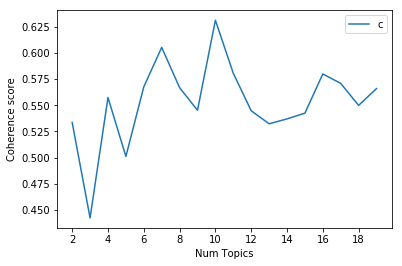

In [35]:
# Show graph
import matplotlib.pyplot as plt

limit=20; start=2; step=1;
x = range(start, limit, step)
plt.xticks([2,4,6,8,10,12,14,16,18,20])
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [56]:
#최적 토픽 수 찾기
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4693
Num Topics = 3  has Coherence Value of 0.5496
Num Topics = 4  has Coherence Value of 0.5568
Num Topics = 5  has Coherence Value of 0.5938
Num Topics = 6  has Coherence Value of 0.5494
Num Topics = 7  has Coherence Value of 0.6115
Num Topics = 8  has Coherence Value of 0.5792
Num Topics = 9  has Coherence Value of 0.5896
Num Topics = 10  has Coherence Value of 0.6149
Num Topics = 11  has Coherence Value of 0.5917
Num Topics = 12  has Coherence Value of 0.5918
Num Topics = 13  has Coherence Value of 0.5854
Num Topics = 14  has Coherence Value of 0.5474
Num Topics = 15  has Coherence Value of 0.5639
Num Topics = 16  has Coherence Value of 0.6
Num Topics = 17  has Coherence Value of 0.5218
Num Topics = 18  has Coherence Value of 0.5365
Num Topics = 19  has Coherence Value of 0.5414


In [79]:
optimal_model = model_list[8]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.014*"겐지" + 0.012*"패치" + 0.011*"상향" + 0.009*"렉사르" + 0.008*"발리라" + '
  '0.007*"디바" + 0.007*"지원" + 0.007*"느낌" + 0.007*"바리안" + 0.006*"은신"'),
 (1,
  '0.028*"영리" + 0.019*"배치" + 0.013*"시즌" + 0.011*"승률" + 0.010*"마스터" + '
  '0.010*"매칭" + 0.009*"골드" + 0.009*"티어" + 0.009*"이상" + 0.008*"시작"'),
 (2,
  '0.010*"특성" + 0.010*"상대" + 0.009*"아군" + 0.008*"가능" + 0.008*"라인" + 0.008*"시간" '
  '+ 0.007*"이상" + 0.007*"조합" + 0.006*"지원" + 0.006*"딜러"'),
 (3,
  '0.008*"경기" + 0.008*"유저" + 0.008*"문제" + 0.005*"선수" + 0.005*"이유" + 0.005*"한국" '
  '+ 0.004*"시스템" + 0.004*"화제" + 0.004*"이상" + 0.004*"채팅"'),
 (4,
  '0.025*"레이너" + 0.013*"워크" + 0.009*"출시" + 0.009*"스킬" + 0.007*"스킨" + '
  '0.007*"마이에브" + 0.007*"스타" + 0.007*"특성" + 0.007*"리밍" + 0.007*"소냐"'),
 (5,
  '0.009*"상자" + 0.007*"방송" + 0.007*"시간" + 0.005*"여고생" + 0.004*"위치" + '
  '0.004*"부탁" + 0.004*"경기" + 0.003*"리그" + 0.003*"감사" + 0.003*"오픈"'),
 (6,
  '0.013*"리리" + 0.012*"힐러" + 0.011*"딜러" + 0.011*"조합" + 0.010*"지원" + '
  '0.009*"크로미" + 0.009*"아나" + 0.008*"탱커" + 0.008*"가로

In [81]:
optimal_model.save("optimal_model")

In [80]:

model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=30))

[(0,
  '0.014*"겐지" + 0.012*"패치" + 0.011*"상향" + 0.009*"렉사르" + 0.008*"발리라" + '
  '0.007*"디바" + 0.007*"지원" + 0.007*"느낌" + 0.007*"바리안" + 0.006*"은신" + '
  '0.006*"라인" + 0.005*"메디브" + 0.005*"사무" + 0.005*"용검" + 0.005*"삭제" + '
  '0.005*"메타" + 0.005*"머키" + 0.005*"전문가" + 0.005*"스킨" + 0.005*"트레" + '
  '0.005*"대회" + 0.004*"노바" + 0.004*"하향" + 0.004*"필요" + 0.004*"캐릭" + '
  '0.004*"암살자" + 0.004*"가능" + 0.003*"한조" + 0.003*"미샤" + 0.003*"워크"'),
 (1,
  '0.028*"영리" + 0.019*"배치" + 0.013*"시즌" + 0.011*"승률" + 0.010*"마스터" + '
  '0.010*"매칭" + 0.009*"골드" + 0.009*"티어" + 0.009*"이상" + 0.008*"시작" + '
  '0.008*"다이아" + 0.007*"실력" + 0.007*"시간" + 0.006*"패치" + 0.006*"친구" + '
  '0.006*"연승" + 0.006*"실버" + 0.006*"수준" + 0.005*"다음" + 0.005*"연패" + 0.005*"조합" '
  '+ 0.005*"유저" + 0.005*"브론즈" + 0.005*"겐지" + 0.005*"플레" + 0.005*"팀원" + '
  '0.005*"이유" + 0.005*"트롤" + 0.005*"상대" + 0.005*"문제"'),
 (2,
  '0.010*"특성" + 0.010*"상대" + 0.009*"아군" + 0.008*"가능" + 0.008*"라인" + 0.008*"시간" '
  '+ 0.007*"이상" + 0.007*"조합" + 0.006*"지원" + 0.006*"딜러" + 

In [82]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      13.498519        1       1 -0.102735 -0.076411
8      12.631458        1       2 -0.168903  0.069590
3      11.545731        1       3  0.134531 -0.083699
6      11.281520        1       4 -0.121755 -0.048926
1      10.719141        1       5  0.055633 -0.174558
9       9.261409        1       6  0.161510  0.069874
4       9.188515        1       7 -0.109655  0.080212
7       8.473659        1       8  0.067623  0.158853
5       7.136513        1       9  0.164240  0.024901
0       6.263535        1      10 -0.080489 -0.019838, topic_info=      Category         Freq Term        Total  loglift  logprob
term                                                           
13859  Default  5652.000000   스킨  5652.000000  30.0000  30.0000
27697  Default  6064.000000   영리  6064.000000  29.0000  29.0000
23035  Default  4653.000000  레이너  4653.000000  28.0000  28.0000
21281  Default  2703.000000   배치  2703.000000  27.0000  27.0000
36997  Default  2340.000000   리리  2340.000000  26.0000  26.0000
7286   Default  2253.000000   시즌  2253.000000  25.0000  25.0000
27667  Default  4910.000000   스킬  4910.000000  24.0000  24.0000
11673  Default  2596.000000   워크  2596.000000  23.0000  23.0000
32570  Default  1995.000000   상향  1995.000000  22.0000  22.0000
15821  Default  2707.000000   평타  2707.000000  21.0000  21.0000
7      Default  4189.000000   겐지  4189.000000  20.0000  20.0000
24055  Default  1635.000000   상자  1635.000000  19.0000  19.0000
1757   Default  2434.000000   힐러  2434.000000  18.0000  18.0000
1781   Default  3448.000000   딜러  3448.000000  17.0000  17.0000
26466  Default  1900.000000   증가  1900.000000  16.0000  16.0000
38695  Default  2404.000000   승률  2404.000000  15.0000  15.0000
16060  Default  2452.000000   아나  2452.000000  14.0000  14.0000
14779  Default  1738.000000  마스터  1738.000000  13.0000  13.0000
12370  Default  5739.000000   특성  5739.000000  12.0000  12.0000
13600  Default  3708.000000   지원  3708.000000  11.0000  11.0000
29552  Default  1114.000000  다이아  1114.000000  10.0000  10.0000
13508  Default  1293.000000   전설  1293.000000   9.0000   9.0000
4303   Default  1828.000000   골드  1828.000000   8.0000   8.0000
37816  Default  4015.000000   패치  4015.000000   7.0000   7.0000
39078  Default  4320.000000   조합  4320.000000   6.0000   6.0000
32344  Default  1960.000000   소냐  1960.000000   5.0000   5.0000
8241   Default  2694.000000   매칭  2694.000000   4.0000   4.0000
14960  Default  2011.000000   출시  2011.000000   3.0000   3.0000
18950  Default  2022.000000   경기  2022.000000   2.0000   2.0000
15297  Default  1920.000000  사거리  1920.000000   1.0000   1.0000
...        ...          ...  ...          ...      ...      ...
8264   Topic10   425.389747   사무   942.282265   1.9751  -5.2273
12734  Topic10   652.162393  발리라  1708.440509   1.8074  -4.8000
28754  Topic10   247.486928   질풍   467.994641   2.1333  -5.7690
7      Topic10  1090.206697   겐지  4189.045880   1.4243  -4.2862
36663  Topic10   583.111938   디바  1807.232965   1.6393  -4.9120
28438  Topic10   377.592537   트레   973.697807   1.8231  -5.3465
11656  Topic10   427.256974  메디브  1234.760637   1.7092  -5.2230
37816  Topic10   930.736473   패치  4015.523244   1.3085  -4.4444
26514  Topic10   512.043838   은신  1663.255210   1.5923  -5.0419
24951  Topic10   389.536368   머키  1422.471333   1.4752  -5.3154
15125  Topic10   392.644616   메타  1485.562435   1.4398  -5.3074
14867  Topic10   517.305472  바리안  2592.806862   1.1586  -5.0317
30072  Topic10   528.112192   느낌  2754.738938   1.1187  -5.0110
4493   Topic10   392.826931   삭제  1712.884532   1.2979  -5.3070
14502  Topic10   383.368871  전문가  1843.866937   1.1998  -5.3313
13600  Topic10   552.863764   지원  3708.487540   0.8672  -4.9652
1664   Topic10   126.461186   음식   228.577792   2.1785  -6.4404
25252  Topic10   156.070963   겐트   343.174567   1.9825  -6.2300
28424  Topic10   318.732331  암살자  1399.452248

### 각 문장에서의 지배적인 토픽 찾기

## 함수 정의

In [54]:
start = time.time()

def format_topics_sentences(ldamodel=lda_model_20, corpus=corpus, texts=df['contents_all']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    
    contents = pd.Series(texts)
    contents_year = pd.Series(df["Year"])
    contents_month = pd.Series(df["Month"])
    contents_day = pd.Series(df["Day"])
    sent_topics_df = pd.concat([sent_topics_df, contents, contents_year, contents_month, contents_day], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df["contents_all"])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Year','Month','Day']

# Show
df_dominant_topic.head(10)

done = time.time()
elapsed = done - start
print(elapsed)

1888.3973288536072


In [55]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Year,Month,Day
0,0,1.0,0.7750,"영리, 배치, 시즌, 승률, 마스터, 매칭, 골드, 티어, 이상, 시작",매칭시스템 문의 다인큐랑 고랩좀 그만만나자,2018,6,27
1,1,1.0,0.7810,"영리, 배치, 시즌, 승률, 마스터, 매칭, 골드, 티어, 이상, 시작",개인등급조절점수 개인등급조절점수 이거 도대체 기준이 뭔가요 연승으로 이기고있...,2018,6,26
2,2,9.0,0.7750,"스킨, 전설, 블리자드, 하스, 와우, 유저, 오버워치, 파편, 상자, 이벤트",그래픽 최적화 좀 하세요 램 겁나먹지 별로 좋지도 않으면서 사양만 엄청타고 ㅡㅡ,2018,6,26
3,3,9.0,0.5002,"스킨, 전설, 블리자드, 하스, 와우, 유저, 오버워치, 파편, 상자, 이벤트",요즘 히오스 끊김 현상 이번 패치 이후로 계속 끊김 현상이 발생합니다 패치이후로 ...,2018,6,26
4,4,2.0,0.6765,"특성, 상대, 아군, 가능, 라인, 시간, 이상, 조합, 지원, 딜러",매칭 시스템 우리는 노탱 상대는 그래도 자리야라는 쉴드탱 킬각 재고싶어도 ...,2018,6,26


In [57]:
df_dominant_topic.to_csv('df_dominant_topic', encoding='utf-8')

In [ ]:
# a = pd.read_csv("df_dominant_topic", encoding='utf-8', engine='python')

### 각 토픽별로 가장 대표적인 문서 찾기

In [61]:
# 정렬해서 다시 만들기

sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0])], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns =  ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text", 'Year', 'Month','Day']

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text,Year,Month,Day
0,0.0,0.9625,"겐지, 패치, 상향, 렉사르, 발리라, 디바, 지원, 느낌, 바리안, 은신",빠대 판중 판에 겐지가 나오네 너무 자주 나와서 최근 판중 몇번 나왔는지 세어...,2018,1,29
1,0.0,0.9571,"겐지, 패치, 상향, 렉사르, 발리라, 디바, 지원, 느낌, 바리안, 은신",머키 물고기의 눈 하향하던가 삭제좀 맵핵이잖아 시 발롬들아 한조 렉사르 음 ...,2018,3,24
2,0.0,0.9571,"겐지, 패치, 상향, 렉사르, 발리라, 디바, 지원, 느낌, 바리안, 은신",화제글 댓글 보면 딜러진에 불만 오지게 많긴 한갑다 피닉스 보호막에 점멸에 딜까지 ...,2018,4,4
3,0.0,0.9526,"겐지, 패치, 상향, 렉사르, 발리라, 디바, 지원, 느낌, 바리안, 은신",마이에브는 진짜 기대된다 히오스에서 딜러말고 암살자 라는 명칭이 어울리는 영웅이...,2018,1,26
4,0.0,0.9471,"겐지, 패치, 상향, 렉사르, 발리라, 디바, 지원, 느낌, 바리안, 은신",특성고착화 고인 누가 먼저 리워크가 돼야 할까 소냐 메디브 트레처럼 성능은 적당한데...,2018,3,19


In [62]:
## 토픽 별 문서 개수

topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
topic_counts


6.0    17134
8.0    16651
1.0    16334
9.0    15838
3.0    15748
4.0    15085
2.0    14430
0.0    12817
7.0    12373
5.0    11085
Name: Dominant_Topic, dtype: int64

### 가장 대표성 띄는 문서 50개 (*주제 넘버링 기준 : 토큰 퍼센트 높은거대로 시각화*)

In [83]:
# 토픽 1 

sent_topics_sorteddf_mallet[sent_topics_sorteddf_mallet['Topic_Num']==2].head(50)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text,Year,Month,Day
29151,2.0,0.9894,"특성, 상대, 아군, 가능, 라인, 시간, 이상, 조합, 지원, 딜러",타워의 포탄갯수제한 건의 이번시즌들어서 대규모로 시스템이 바뀌었습니다 다른건 ...,2018,1,19
29152,2.0,0.9852,"특성, 상대, 아군, 가능, 라인, 시간, 이상, 조합, 지원, 딜러",화이트메인하면 너무 피곤함 말퓨 메커니즘과 비슷하게 생각하는 경우가 있는데 말퓨보...,2018,8,10
29153,2.0,0.9836,"특성, 상대, 아군, 가능, 라인, 시간, 이상, 조합, 지원, 딜러",크로미 너프좀 하자 정도껏 사기로 만들어야지 얼마나 사기면 꼭 항상 게임 판마다 ...,2017,10,29
29154,2.0,0.9800,"특성, 상대, 아군, 가능, 라인, 시간, 이상, 조합, 지원, 딜러",제가 생각하는 켈타스 특성 렙 비전보호막 이거 안가면 생존이 어려움 렙 사...,2018,5,25
29155,2.0,0.9795,"특성, 상대, 아군, 가능, 라인, 시간, 이상, 조합, 지원, 딜러",장애네 디바린가 핫바진가 멀 계속 쳐건들고 이상하게 만드는거야전문가로 상대몹이랑 ...,2017,12,28
29156,2.0,0.9786,"특성, 상대, 아군, 가능, 라인, 시간, 이상, 조합, 지원, 딜러",퀘스트 늘어나는게 왜 불만임 퀘스트 늘어나면서 생길 상황은 레벨로 상대...,2017,10,20
29157,2.0,0.9786,"특성, 상대, 아군, 가능, 라인, 시간, 이상, 조합, 지원, 딜러",전문가 죽이기 패치 잘하셧음 멀 계속 쳐건들고 이상하게 만드는거야전문가로 상대...,2017,12,28
29158,2.0,0.9750,"특성, 상대, 아군, 가능, 라인, 시간, 이상, 조합, 지원, 딜러",막기 특성에 개편이 필요한 건 맞지 않나 특수한 경우 머키의 방어 를 제외하면 대...,2018,2,25
29159,2.0,0.9750,"특성, 상대, 아군, 가능, 라인, 시간, 이상, 조합, 지원, 딜러",하향먹어도 한조그메가 나올수밖에 없는이유 투사나 공성캠프를 쉽게 먹을수있는게 큼예를...,2018,5,10
29160,2.0,0.9719,"특성, 상대, 아군, 가능, 라인, 시간, 이상, 조합, 지원, 딜러",이전 디아가 무슨 메인딜러급이라고 하는데 그거 굉장히 특정한 상황에서 상대방이 ...,2018,5,23


In [84]:
# 토픽 2 :

sent_topics_sorteddf_mallet[sent_topics_sorteddf_mallet['Topic_Num']==8].head(50)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text,Year,Month,Day
115006,8.0,0.9808,"스킬, 평타, 특성, 증가, 사거리, 체력, 기본, 노바, 바리안, 공격",티란데 리워크 사냥꾼의 징표 지속효과 추가 방어력이 이상 감소된 상...,2018,1,27
115007,8.0,0.9750,"스킬, 평타, 특성, 증가, 사거리, 체력, 기본, 노바, 바리안, 공격",마이에브 디자인한 사람이 티리엘 디자인했으면 대천사의 분노사용하면 초 후...,2018,2,16
115008,8.0,0.9735,"스킬, 평타, 특성, 증가, 사거리, 체력, 기본, 노바, 바리안, 공격",레이너 상향안 겸 스킬 리메이크 전방으로 총알 난사하면서 이동한다 수류탄을 던...,2017,11,8
115009,8.0,0.9710,"스킬, 평타, 특성, 증가, 사거리, 체력, 기본, 노바, 바리안, 공격",그때 거강 개쓰레기었는데 전쟁인도자 변경 후 바리안 기본스펙 어마무시하게 올랐고그걸...,2018,1,4
115010,8.0,0.9700,"스킬, 평타, 특성, 증가, 사거리, 체력, 기본, 노바, 바리안, 공격",레이너 패시브를 다른 몇명의 딜러와 비교 레이너 눈이 좋아져서 시야와 사거리가...,2018,2,2
115011,8.0,0.9700,"스킬, 평타, 특성, 증가, 사거리, 체력, 기본, 노바, 바리안, 공격",레이너 리메이크 방안 고유 능력 돌격병 처치시 공격력 적 처치 ...,2017,10,24
115012,8.0,0.9690,"스킬, 평타, 특성, 증가, 사거리, 체력, 기본, 노바, 바리안, 공격",이렐 적절한 상향안 풀차징 시간을 초에서 초로 단축 차징시 캔슬당하...,2018,6,15
115013,8.0,0.9690,"스킬, 평타, 특성, 증가, 사거리, 체력, 기본, 노바, 바리안, 공격",겐지는 뭐가 ㅈ같은건지 알겠음 생존 무적 그딴거 다 재껴두고 질풍참 이게 문제임...,2018,1,26
115014,8.0,0.9679,"스킬, 평타, 특성, 증가, 사거리, 체력, 기본, 노바, 바리안, 공격",저격글 처음 적중하는 적에게 의 피해를 줍니다 성장치는 레벨당 고요 사거리는 ...,2018,5,15
115015,8.0,0.9679,"스킬, 평타, 특성, 증가, 사거리, 체력, 기본, 노바, 바리안, 공격",디바는 이걸 줬으면 좋겠네요 로봇 이속은 타 영웅과 동일하게 상향 평타 사용중...,2018,5,22


In [85]:
# 토픽 3

sent_topics_sorteddf_mallet[sent_topics_sorteddf_mallet['Topic_Num']==3].head(50)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text,Year,Month,Day
43581,3.0,0.9800,"경기, 유저, 문제, 선수, 이유, 한국, 시스템, 화제, 이상, 채팅",신고 시스템이 제대로 작동하는 것이 맞나요 안녕하세요 비록 내일 군대를 가지만...,2018,1,27
43582,3.0,0.9800,"경기, 유저, 문제, 선수, 이유, 한국, 시스템, 화제, 이상, 채팅",인벤보다가 어이없는 운영작태를 보고 히오스는 진짜 입을 다물고 해야함 전에 ...,2017,12,24
43583,3.0,0.9786,"경기, 유저, 문제, 선수, 이유, 한국, 시스템, 화제, 이상, 채팅",그냥 히오스 제제시스템은 망했음 왜냐 결국은 게임상 트롤은 언제나존재하는데 그사람...,2017,10,14
43584,3.0,0.9780,"경기, 유저, 문제, 선수, 이유, 한국, 시스템, 화제, 이상, 채팅",채팅금지 시스템 개선좀 해주세요 처럼 최대 일 제한을 하던가 무조건 식으로 ...,2017,11,29
43585,3.0,0.9763,"경기, 유저, 문제, 선수, 이유, 한국, 시스템, 화제, 이상, 채팅",재접속 장문이라 무시하지말고 하 진짜 개빡치네 재접속좀 합시다 제발 아...,2017,9,5
43586,3.0,0.9750,"경기, 유저, 문제, 선수, 이유, 한국, 시스템, 화제, 이상, 채팅",이번 렐릭사건 제가 건드릴 일은 아니지만 레딧 반응이라도 올리고 싶네요 왜 레딧에서...,2018,5,30
43587,3.0,0.9743,"경기, 유저, 문제, 선수, 이유, 한국, 시스템, 화제, 이상, 채팅",쓰레기같은 운영에 치가 떨린다 영웅리그에 고의트롤이 넘쳐나는데도 제제도 안하고문의...,2018,4,29
43588,3.0,0.9743,"경기, 유저, 문제, 선수, 이유, 한국, 시스템, 화제, 이상, 채팅",화제글 군대사건 보고 생각난 옛날 이야기 우리 부대에 군견병이 있었는데군견병 평소에...,2018,5,29
43589,3.0,0.9743,"경기, 유저, 문제, 선수, 이유, 한국, 시스템, 화제, 이상, 채팅",유저 관리좀 부탁합니다 블리자드 유저관리좀 해주면 안됨등급전에서 실력이 없어도 ...,2017,9,10
43590,3.0,0.9735,"경기, 유저, 문제, 선수, 이유, 한국, 시스템, 화제, 이상, 채팅",도타는 트롤하면 스팀아이디도 제재하는데 여긴ㅋ 금방 글제목에 욕을써놓으니 글이안올...,2018,2,15


In [86]:
# 토픽 4

sent_topics_sorteddf_mallet[sent_topics_sorteddf_mallet['Topic_Num']==6].head(50)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text,Year,Month,Day
85499,6.0,0.9889,"리리, 힐러, 딜러, 조합, 지원, 크로미, 아나, 탱커, 가로쉬, 말티엘",히린이인데 질문좀여 요즘 히오스 본격적으로 해보려 하는 히린이입니다 히오스를 시작...,2017,11,7
85500,6.0,0.9878,"리리, 힐러, 딜러, 조합, 지원, 크로미, 아나, 탱커, 가로쉬, 말티엘",심심해서 써보는 부터 지금까지의 주간수집품 발라 ...,2018,2,3
85501,6.0,0.9878,"리리, 힐러, 딜러, 조합, 지원, 크로미, 아나, 탱커, 가로쉬, 말티엘",지금까지의 주간수집품 레오릭 제이나 ...,2018,3,3
85502,6.0,0.9795,"리리, 힐러, 딜러, 조합, 지원, 크로미, 아나, 탱커, 가로쉬, 말티엘",히린인데여 저는 컴퓨터랑만 게임하는 히린인데여 제가 영웅에 대해 아는게 대부분 ...,2018,7,31
85503,6.0,0.9786,"리리, 힐러, 딜러, 조합, 지원, 크로미, 아나, 탱커, 가로쉬, 말티엘",뉴비에게 권해보는 주관적 명의 영웅들 굳이 영웅을 채운다하면탱커 누더기 소냐 ...,2018,1,14
85504,6.0,0.9757,"리리, 힐러, 딜러, 조합, 지원, 크로미, 아나, 탱커, 가로쉬, 말티엘",이번 카봇 포트레이트에 없는 영웅 아눕아락 아서스 아우리엘 아즈모단 카시...,2018,3,30
85505,6.0,0.9727,"리리, 힐러, 딜러, 조합, 지원, 크로미, 아나, 탱커, 가로쉬, 말티엘",대회 보고 느낀점 마엡 말퓨 우서 벤으로 시작함 나오는 전사 티어 가로쉬 ...,2018,3,19
85506,6.0,0.9719,"리리, 힐러, 딜러, 조합, 지원, 크로미, 아나, 탱커, 가로쉬, 말티엘",영리 입문 시기 인공지능대전만 즐기다가 지금은 빠대만 하고 있구요 레벨 이...,2017,12,4
85507,6.0,0.9710,"리리, 힐러, 딜러, 조합, 지원, 크로미, 아나, 탱커, 가로쉬, 말티엘",예전에 썼던 글이지만 줄은 섭탱은 못허고 제 포지션낙뢰스랄 너프전 알라라크등이 ...,2018,5,3
85508,6.0,0.9700,"리리, 힐러, 딜러, 조합, 지원, 크로미, 아나, 탱커, 가로쉬, 말티엘",지원가 조합하려면 우서 메인탱 아군의 생존 카라짐 레가르 섭탱 세이브능력...,2017,10,8


In [87]:
# 토픽 5

sent_topics_sorteddf_mallet[sent_topics_sorteddf_mallet['Topic_Num']==1].head(50)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text,Year,Month,Day
12817,1.0,0.9857,"영리, 배치, 시즌, 승률, 마스터, 매칭, 골드, 티어, 이상, 시작",히오스 문제점 팩트 정리 히오스 문제점은 엄청나게 많습니다최근에 히오스 시스템이 ...,2018,2,5
12818,1.0,0.9836,"영리, 배치, 시즌, 승률, 마스터, 매칭, 골드, 티어, 이상, 시작",영리 실버 에서 브론즈 까지 곤두박질쳤음 안녕하세요 지난번에 영리 실버 에서 실버 ...,2018,6,29
12819,1.0,0.9800,"영리, 배치, 시즌, 승률, 마스터, 매칭, 골드, 티어, 이상, 시작",장문 히오스 티어계산 티어부심 사진 보고 심심해서 추가계산해봄 승률은 대부분...,2017,9,9
12820,1.0,0.9780,"영리, 배치, 시즌, 승률, 마스터, 매칭, 골드, 티어, 이상, 시작",지쳤습니다 네 베타때 잠깐 하다가 노잼이라서 접고 히오스의 해라고 ...,2018,1,1
12821,1.0,0.9780,"영리, 배치, 시즌, 승률, 마스터, 매칭, 골드, 티어, 이상, 시작",ㅋㅋ 진심 정떨어지게 하네 티어 ㅈㄷ의미없는거 내가 마스터 승급전을 번을 갓는...,2018,6,4
12822,1.0,0.9757,"영리, 배치, 시즌, 승률, 마스터, 매칭, 골드, 티어, 이상, 시작",부탁인데 걍 배치를 없애라 다똑같이 브론즈데서시작하자 아니 히오스에서는 등급이 등...,2017,9,21
12823,1.0,0.9750,"영리, 배치, 시즌, 승률, 마스터, 매칭, 골드, 티어, 이상, 시작",전부 다 리셋하는 건 어때요 영리에서 난리가 났을 때 리셋을 고...,2018,4,14
12824,1.0,0.9719,"영리, 배치, 시즌, 승률, 마스터, 매칭, 골드, 티어, 이상, 시작",히린이 배치봤는데요 예전에 롤 한참 하다 핵판칠때 떠나고최근들어 우연히 히오스...,2018,8,19
12825,1.0,0.9710,"영리, 배치, 시즌, 승률, 마스터, 매칭, 골드, 티어, 이상, 시작",아 금욜에 입실렌티가서 응원제할때 별 난리부르스를 다떨었더니 등 허리 배 다리 목 ...,2018,5,27
12826,1.0,0.9690,"영리, 배치, 시즌, 승률, 마스터, 매칭, 골드, 티어, 이상, 시작",빠대가 문제가 되는건 영리와 연계되는게 문제임 아무런 운영도 배울 수 없는 모드고밴...,2017,9,11


In [88]:
# 토픽 6

sent_topics_sorteddf_mallet[sent_topics_sorteddf_mallet['Topic_Num']==9].head(50)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text,Year,Month,Day
131657,9.0,0.9850,"스킨, 전설, 블리자드, 하스, 와우, 유저, 오버워치, 파편, 상자, 이벤트",히오스만 끊김 버벅임 현상 히오스만 끊김 버벅임 현상블리자드 게임 오버워치 와우...,2018,2,5
131658,9.0,0.9690,"스킨, 전설, 블리자드, 하스, 와우, 유저, 오버워치, 파편, 상자, 이벤트",게임 준비 버튼 비활성화 게임 시작을 못하고 있습니다 예전에 이런 증상이 나오면 ...,2018,6,14
131659,9.0,0.9678,"스킨, 전설, 블리자드, 하스, 와우, 유저, 오버워치, 파편, 상자, 이벤트",나 지금 메일 문의 넣고왔다 혹시라도 갈사람있으면 얘기하세요 지금 본사 주소랑 ...,2017,11,20
131660,9.0,0.9591,"스킨, 전설, 블리자드, 하스, 와우, 유저, 오버워치, 파편, 상자, 이벤트",메카 티리엘 영웅 특유 탈것 메카 티리엘 구매했는데 탈것이 계속 말이고 영웅특유탈...,2018,3,17
131661,9.0,0.9550,"스킨, 전설, 블리자드, 하스, 와우, 유저, 오버워치, 파편, 상자, 이벤트",유료로 일반가정집에서도 피씨방 혜택 주세요 월정액으로 피씨방혜택 받을수 있게 시...,2018,2,17
131662,9.0,0.9526,"스킨, 전설, 블리자드, 하스, 와우, 유저, 오버워치, 파편, 상자, 이벤트",일반 가정집에서도 유료로 피씨방 혜택 주는게 어떨까요 월정액으로 피씨방혜택 받을...,2018,2,17
131663,9.0,0.9500,"스킨, 전설, 블리자드, 하스, 와우, 유저, 오버워치, 파편, 상자, 이벤트",유료로 가정집에서도 피씨방 혜택을 월정액으로 피씨방혜택 받을수 있게 시스템 ...,2018,2,17
131664,9.0,0.9500,"스킨, 전설, 블리자드, 하스, 와우, 유저, 오버워치, 파편, 상자, 이벤트",스킨 정책을 재정비 해야하지 않을까 시작 될때 파편으로 스킨 살 수 있다...,2017,9,17
131665,9.0,0.9500,"스킨, 전설, 블리자드, 하스, 와우, 유저, 오버워치, 파편, 상자, 이벤트",배틀필드 엄청 까이네 배필 공식 트레일러가 나왔는데 기존 배틀필드에서 벗어난...,2018,5,24
131666,9.0,0.9500,"스킨, 전설, 블리자드, 하스, 와우, 유저, 오버워치, 파편, 상자, 이벤트",피씨방혜택 유료로 가정집에서도 할수 있기를 월정액으로 피씨방혜택 받을수...,2018,2,17


In [89]:
# 토픽 7

sent_topics_sorteddf_mallet[sent_topics_sorteddf_mallet['Topic_Num']==4].head(50)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text,Year,Month,Day
59329,4.0,0.9757,"레이너, 워크, 출시, 스킬, 스킨, 마이에브, 스타, 특성, 리밍, 소냐",재미로 보는 내 아바투르 맵별 승률 빠대만 반영함 아바투르 렙 ...,2017,12,3
59330,4.0,0.9743,"레이너, 워크, 출시, 스킬, 스킨, 마이에브, 스타, 특성, 리밍, 소냐",오랜만에 스 미션 다시해보는데 할 게임 없다 으어 하고 무심코 켰더니 너무 ...,2018,8,15
59331,4.0,0.9690,"레이너, 워크, 출시, 스킬, 스킨, 마이에브, 스타, 특성, 리밍, 소냐",주관 지금 절실하게 리워크 필요한 애들 완벽한 상위호환의 존재가 있거나다른 영웅과 ...,2018,1,23
59332,4.0,0.9654,"레이너, 워크, 출시, 스킬, 스킨, 마이에브, 스타, 특성, 리밍, 소냐",이번 공개된 전장이 볼스카야가 끝이 아니다 한 히오스 유튜버가 그러더군요옛...,2017,9,26
59333,4.0,0.9591,"레이너, 워크, 출시, 스킬, 스킨, 마이에브, 스타, 특성, 리밍, 소냐",전문가 암살자 취급하는 매칭 언제 수정 우리팀 나지보 머키 자가라 아눕 아나인데...,2018,6,3
59334,4.0,0.9526,"레이너, 워크, 출시, 스킬, 스킨, 마이에브, 스타, 특성, 리밍, 소냐",케인 특성 특급 생명력 물약 존나 함정특인거 같은데 나만느낌 정작 뿌리고는 잇는...,2018,7,9
59335,4.0,0.9526,"레이너, 워크, 출시, 스킬, 스킨, 마이에브, 스타, 특성, 리밍, 소냐",스타크래프트 영웅들 관심은 많은데 프로비우스 얘는 쓰레기인데 귀엽다고 좋아해주고 ...,2017,10,25
59336,4.0,0.9526,"레이너, 워크, 출시, 스킬, 스킨, 마이에브, 스타, 특성, 리밍, 소냐",울트라 안나온걸로도 이미 블쟈는 뚜까맞아야한다 스타뿐아니라 블쟈세계관 전체를 통털어...,2018,5,31
59337,4.0,0.9500,"레이너, 워크, 출시, 스킬, 스킨, 마이에브, 스타, 특성, 리밍, 소냐",볼스카야가 마음에 안드는점 다른 곳을보면 거기 주인이힘을 빌려주는듯하거나 사원 거미...,2017,10,23
59338,4.0,0.9500,"레이너, 워크, 출시, 스킬, 스킨, 마이에브, 스타, 특성, 리밍, 소냐",아르타니스 정화광선이 옆동네 요들궁마냥일직선으로 쫙 긋고 장판슬로우를 주는 궁...,2018,2,4


In [90]:
# 토픽 8 

sent_topics_sorteddf_mallet[sent_topics_sorteddf_mallet['Topic_Num']==7].head(50)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text,Year,Month,Day
102633,7.0,0.9700,"영상, 호드, 여자, 후방, 남자, 와우, 전쟁, 이름, 가능, 영화",딴 게임입니다 관심 있으신 분들만 클릭 칸코레 같은 거 아니구요 ...,2018,6,24
102634,7.0,0.9571,"영상, 호드, 여자, 후방, 남자, 와우, 전쟁, 이름, 가능, 영화",여자 많은 곳 가면 여친 생길거 같지 친구 동생이간호학과인데얘가 키 작은거 빼면얼...,2017,12,31
102635,7.0,0.9550,"영상, 호드, 여자, 후방, 남자, 와우, 전쟁, 이름, 가능, 영화",이렐보고 듣보라고 한 이유 그냥 듣보가 아니라 상대적 듣보란 얘기임 드군때 얼라이언...,2018,6,3
102636,7.0,0.9526,"영상, 호드, 여자, 후방, 남자, 와우, 전쟁, 이름, 가능, 영화",걍 군단스토리보면 제이나 걍 신경안쓰고 스토리 전개한거같은데 블쟈놈들 퍼 제이나가...,2017,9,5
102637,7.0,0.9471,"영상, 호드, 여자, 후방, 남자, 와우, 전쟁, 이름, 가능, 영화",와우에 언젠간 아재로스의 전쟁군주도 나올듯 고대신에 의해 파괴된 행성분열직전 아재...,2018,2,6
102638,7.0,0.9470,"영상, 호드, 여자, 후방, 남자, 와우, 전쟁, 이름, 가능, 영화",지금 존나 흥미진진하다 포차같은곳에서 술마시고있는데 옆테이블에서 회사회식인듯한데 히...,2017,9,26
102639,7.0,0.9470,"영상, 호드, 여자, 후방, 남자, 와우, 전쟁, 이름, 가능, 영화",방금 와우 텔드랏실 스포보고왔는데 난 진짜 황혼의망치단같은 제 세력이 텔드랏실 ...,2018,2,14
102640,7.0,0.9470,"영상, 호드, 여자, 후방, 남자, 와우, 전쟁, 이름, 가능, 영화",실바나스는 보면 볼수록 뭔지 와우버전 케리건에민폐란 민폐는 다 끼치고 호드에서...,2018,2,4
102641,7.0,0.9437,"영상, 호드, 여자, 후방, 남자, 와우, 전쟁, 이름, 가능, 영화",제가 오따끄라서 북두의권을 아는건가요 막 북두의권 죠죠 이런거 패러디같은건오따끄아니...,2018,4,19
102642,7.0,0.9437,"영상, 호드, 여자, 후방, 남자, 와우, 전쟁, 이름, 가능, 영화",정부청사 앞 패미니즘시위 다 좋은데 여권 신장 주장하기전에 군방의 의무를 수행할 권...,2018,5,31


In [91]:
# 토픽 9

sent_topics_sorteddf_mallet[sent_topics_sorteddf_mallet['Topic_Num']==5].head(50)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text,Year,Month,Day
74414,5.0,0.9830,"상자, 방송, 시간, 여고생, 위치, 부탁, 경기, 리그, 감사, 오픈",수요일 시 김영일 빈본 티세론 해설의 오픈 디비전 회차 강전 중계안내...,2018,3,6
74415,5.0,0.9827,"상자, 방송, 시간, 여고생, 위치, 부탁, 경기, 리그, 감사, 오픈",수요일 시 최광원 빈본 홍코노 해설의 오픈 디비전 회차 강전 중계안내...,2018,4,17
74416,5.0,0.9769,"상자, 방송, 시간, 여고생, 위치, 부탁, 경기, 리그, 감사, 오픈",목요일 시 최광원 네클릿 나초진 중계 오픈 디비전 회차 결승전 위...,2018,4,11
74417,5.0,0.9769,"상자, 방송, 시간, 여고생, 위치, 부탁, 경기, 리그, 감사, 오픈",목요일 시 최광원 빈본 홍코노 중계 오픈 디비전 회차 결승전 위전...,2018,4,18
74418,5.0,0.9763,"상자, 방송, 시간, 여고생, 위치, 부탁, 경기, 리그, 감사, 오픈",목요일 시 김영일 빈본 티세론 중계 오픈 디비전 회차 결승전 위전...,2018,3,7
74419,5.0,0.9625,"상자, 방송, 시간, 여고생, 위치, 부탁, 경기, 리그, 감사, 오픈",오픈 디비전 시즌 일정 변경 안내 안녕하세요 인벤방송국입니다 오...,2018,4,9
74420,5.0,0.9609,"상자, 방송, 시간, 여고생, 위치, 부탁, 경기, 리그, 감사, 오픈",방구석리그 후기입니다 매번 팀 단위로 신청을 받아서 손가락만 빨고 있었는데시공...,2017,9,10
74421,5.0,0.9591,"상자, 방송, 시간, 여고생, 위치, 부탁, 경기, 리그, 감사, 오픈",이스턴 클래시 보려고 호텔 예약했어요 와이프가 게임 하는 거 안 좋아하는데ㅠ여름 휴...,2018,8,14
74422,5.0,0.9571,"상자, 방송, 시간, 여고생, 위치, 부탁, 경기, 리그, 감사, 오픈",형들 대만 현장에서 선수들 인터뷰임 즐감해줘잉 아재이욱의 이스턴 클래시 ...,2018,3,16
74423,5.0,0.9514,"상자, 방송, 시간, 여고생, 위치, 부탁, 경기, 리그, 감사, 오픈",목요일 시 최광원 네클릿 블루비틀 중계 오픈디비전 회차 결승전 ...,2018,8,1


In [93]:
# 토픽 10

sent_topics_sorteddf_mallet[sent_topics_sorteddf_mallet['Topic_Num']==0].head(50)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text,Year,Month,Day
0,0.0,0.9625,"겐지, 패치, 상향, 렉사르, 발리라, 디바, 지원, 느낌, 바리안, 은신",빠대 판중 판에 겐지가 나오네 너무 자주 나와서 최근 판중 몇번 나왔는지 세어...,2018,1,29
1,0.0,0.9571,"겐지, 패치, 상향, 렉사르, 발리라, 디바, 지원, 느낌, 바리안, 은신",머키 물고기의 눈 하향하던가 삭제좀 맵핵이잖아 시 발롬들아 한조 렉사르 음 ...,2018,3,24
2,0.0,0.9571,"겐지, 패치, 상향, 렉사르, 발리라, 디바, 지원, 느낌, 바리안, 은신",화제글 댓글 보면 딜러진에 불만 오지게 많긴 한갑다 피닉스 보호막에 점멸에 딜까지 ...,2018,4,4
3,0.0,0.9526,"겐지, 패치, 상향, 렉사르, 발리라, 디바, 지원, 느낌, 바리안, 은신",마이에브는 진짜 기대된다 히오스에서 딜러말고 암살자 라는 명칭이 어울리는 영웅이...,2018,1,26
4,0.0,0.9471,"겐지, 패치, 상향, 렉사르, 발리라, 디바, 지원, 느낌, 바리안, 은신",특성고착화 고인 누가 먼저 리워크가 돼야 할까 소냐 메디브 트레처럼 성능은 적당한데...,2018,3,19
5,0.0,0.9437,"겐지, 패치, 상향, 렉사르, 발리라, 디바, 지원, 느낌, 바리안, 은신",정식오픈 후 직업군 별 출시 수 마이에브까지 전사 명암살자 명전문가 명지원가...,2018,1,29
6,0.0,0.9437,"겐지, 패치, 상향, 렉사르, 발리라, 디바, 지원, 느낌, 바리안, 은신",겐지너프는 질풍참을 너프해야함 빠른 기동력을 바탕으로 킬캐치능력이 뛰어나니까 프로들...,2018,1,23
7,0.0,0.9437,"겐지, 패치, 상향, 렉사르, 발리라, 디바, 지원, 느낌, 바리안, 은신",못난것보다 어중간한게 더 나쁘다고 레이너처럼 써먹을 용도가 없어서 버려지는 것보다렉...,2018,3,22
8,0.0,0.9400,"겐지, 패치, 상향, 렉사르, 발리라, 디바, 지원, 느낌, 바리안, 은신",발리라 끝남 기력관리 잘되던 매복트리 사장시키고 특성은 렙특보다 구리고소멸컷은 더...,2017,11,6
9,0.0,0.9400,"겐지, 패치, 상향, 렉사르, 발리라, 디바, 지원, 느낌, 바리안, 은신",그냥 지원가 하향했듯이 오버워치 암살자 아바 메디브 제외 제외 모든 암살자 전문가 ...,2018,5,7


## 토픽 분기분석

In [94]:
## Autumn(1분기)

month_9 = sent_topics_sorteddf_mallet[sent_topics_sorteddf_mallet.Month==9]
month_10 = sent_topics_sorteddf_mallet[sent_topics_sorteddf_mallet.Month==10]
month_11 = sent_topics_sorteddf_mallet[sent_topics_sorteddf_mallet.Month==11]

In [95]:
## Winter(2분기)

month_12 = sent_topics_sorteddf_mallet[sent_topics_sorteddf_mallet.Month==12]
month_1 = sent_topics_sorteddf_mallet[sent_topics_sorteddf_mallet.Month==1]
month_2 = sent_topics_sorteddf_mallet[sent_topics_sorteddf_mallet.Month==2]

In [96]:
## Spring (3분기)

month_3 = sent_topics_sorteddf_mallet[sent_topics_sorteddf_mallet.Month==3]
month_4 = sent_topics_sorteddf_mallet[sent_topics_sorteddf_mallet.Month==4]
month_5 = sent_topics_sorteddf_mallet[sent_topics_sorteddf_mallet.Month==5]

In [97]:
## Summer (4분기)

month_6 = sent_topics_sorteddf_mallet[sent_topics_sorteddf_mallet.Month==6]
month_7 = sent_topics_sorteddf_mallet[sent_topics_sorteddf_mallet.Month==7]
month_8 = sent_topics_sorteddf_mallet[sent_topics_sorteddf_mallet.Month==8]

In [98]:
### 데이터 분기별로 합치고 새 열로 만들어 줍니다.

autumn_df = pd.concat([month_9, month_10, month_11])
winter_df = pd.concat([month_12, month_1, month_2])
spring_df = pd.concat([month_3, month_4, month_5])
summer_df = pd.concat([month_6, month_7, month_8])

In [69]:
print("1분기: ",len(autumn_df))
print("2분기: ",len(winter_df))
print("3분기: ",len(spring_df))
print("4분기: ",len(summer_df))

1분기:  43868
2분기:  51441
3분기:  43676
4분기:  8510


### 2 8 3 6 1 9 4 7 5 0

### 분기별 분석 - 가을

In [105]:
print("주제 1 문서갯수:",len(autumn_df[autumn_df['Topic_Num']==2]))
print("주제 2 문서갯수:",len(autumn_df[autumn_df['Topic_Num']==8]))
print("주제 3 문서갯수:",len(autumn_df[autumn_df['Topic_Num']==3]))
print("주제 4 문서갯수:",len(autumn_df[autumn_df['Topic_Num']==6]))
print("주제 5 문서갯수:",len(autumn_df[autumn_df['Topic_Num']==1]))
print("주제 6 문서갯수:",len(autumn_df[autumn_df['Topic_Num']==9]))
print("주제 7 문서갯수:",len(autumn_df[autumn_df['Topic_Num']==4]))
print("주제 8 문서갯수:",len(autumn_df[autumn_df['Topic_Num']==7]))
print("주제 9 문서갯수:",len(autumn_df[autumn_df['Topic_Num']==5]))
print("주제 10 문서갯수:",len(autumn_df[autumn_df['Topic_Num']==0]))

주제 1 문서갯수: 4782
주제 2 문서갯수: 5370
주제 3 문서갯수: 4152
주제 4 문서갯수: 5571
주제 5 문서갯수: 4253
주제 6 문서갯수: 5013
주제 7 문서갯수: 4034
주제 8 문서갯수: 3758
주제 9 문서갯수: 3289
주제 10 문서갯수: 3646


### 분기별 분석 - 겨울

In [106]:
print("주제 1 문서갯수:",len(winter_df[winter_df['Topic_Num']==2]))
print("주제 2 문서갯수:",len(winter_df[winter_df['Topic_Num']==8]))
print("주제 3 문서갯수:",len(winter_df[winter_df['Topic_Num']==3]))
print("주제 4 문서갯수:",len(winter_df[winter_df['Topic_Num']==6]))
print("주제 5 문서갯수:",len(winter_df[winter_df['Topic_Num']==1]))
print("주제 6 문서갯수:",len(winter_df[winter_df['Topic_Num']==9]))
print("주제 7 문서갯수:",len(winter_df[winter_df['Topic_Num']==4]))
print("주제 8 문서갯수:",len(winter_df[winter_df['Topic_Num']==7]))
print("주제 9 문서갯수:",len(winter_df[winter_df['Topic_Num']==5]))
print("주제 10 문서갯수:",len(winter_df[winter_df['Topic_Num']==0]))


주제 1 문서갯수: 4849
주제 2 문서갯수: 5240
주제 3 문서갯수: 5483
주제 4 문서갯수: 5886
주제 5 문서갯수: 6153
주제 6 문서갯수: 5722
주제 7 문서갯수: 5343
주제 8 문서갯수: 4337
주제 9 문서갯수: 3917
주제 10 문서갯수: 4511


### 분기별 분석 - 봄

In [107]:
print("주제 1 문서갯수:",len(spring_df[spring_df['Topic_Num']==2]))
print("주제 2 문서갯수:",len(spring_df[spring_df['Topic_Num']==8]))
print("주제 3 문서갯수:",len(spring_df[spring_df['Topic_Num']==3]))
print("주제 4 문서갯수:",len(spring_df[spring_df['Topic_Num']==6]))
print("주제 5 문서갯수:",len(spring_df[spring_df['Topic_Num']==1]))
print("주제 6 문서갯수:",len(spring_df[spring_df['Topic_Num']==9]))
print("주제 7 문서갯수:",len(spring_df[spring_df['Topic_Num']==4]))
print("주제 8 문서갯수:",len(spring_df[spring_df['Topic_Num']==7]))
print("주제 9 문서갯수:",len(spring_df[spring_df['Topic_Num']==5]))
print("주제 10 문서갯수:",len(spring_df[spring_df['Topic_Num']==0]))

주제 1 문서갯수: 4018
주제 2 문서갯수: 5365
주제 3 문서갯수: 4455
주제 4 문서갯수: 4755
주제 5 문서갯수: 4693
주제 6 문서갯수: 4314
주제 7 문서갯수: 5076
주제 8 문서갯수: 3726
주제 9 문서갯수: 3262
주제 10 문서갯수: 4012


### 분기별 분석 - 여름

In [108]:
print("주제 1 문서갯수:",len(summer_df[summer_df['Topic_Num']==2]))
print("주제 2 문서갯수:",len(summer_df[summer_df['Topic_Num']==8]))
print("주제 3 문서갯수:",len(summer_df[summer_df['Topic_Num']==3]))
print("주제 4 문서갯수:",len(summer_df[summer_df['Topic_Num']==6]))
print("주제 5 문서갯수:",len(summer_df[summer_df['Topic_Num']==1]))
print("주제 6 문서갯수:",len(summer_df[summer_df['Topic_Num']==9]))
print("주제 7 문서갯수:",len(summer_df[summer_df['Topic_Num']==4]))
print("주제 8 문서갯수:",len(summer_df[summer_df['Topic_Num']==7]))
print("주제 9 문서갯수:",len(summer_df[summer_df['Topic_Num']==5]))
print("주제 10 문서갯수:",len(summer_df[summer_df['Topic_Num']==0]))

주제 1 문서갯수: 781
주제 2 문서갯수: 676
주제 3 문서갯수: 1658
주제 4 문서갯수: 922
주제 5 문서갯수: 1235
주제 6 문서갯수: 789
주제 7 문서갯수: 632
주제 8 문서갯수: 552
주제 9 문서갯수: 617
주제 10 문서갯수: 648


## 일정 시점별 빈도분석 - 아래 이후로는 코드만 있고 주제만 바꿔서 쓰면 됩니다.

---

1. 2017.9.1 ~ 2017.12.13
2. 2017.12.14 ~ 2018.4.15
3. 2018.4.16 ~ 2018.8.31

In [ ]:

# 매칭 1분기의 12/1~12/13만
match_1 = sent_topics_sorteddf_mallet[((sent_topics_sorteddf_mallet.Month==12)
                             &(sent_topics_sorteddf_mallet.Day<=13))]

# 매칭 2분기 12/14~ 와 ~4/15까지
match_2_1 = sent_topics_sorteddf_mallet[((sent_topics_sorteddf_mallet.Month==12)
                                         &(sent_topics_sorteddf_mallet.Day>=14))]

match_2_2 = sent_topics_sorteddf_mallet[((sent_topics_sorteddf_mallet.Month==4)
                                         &(sent_topics_sorteddf_mallet.Day<=15))]


# 매칭 3분기 4~16
match_3 = sent_topics_sorteddf_mallet[((sent_topics_sorteddf_mallet.Month==4)
                                      &(sent_topics_sorteddf_mallet.Day>=16))]

In [ ]:
match_df_1 = pd.concat([month_9, month_10, month_11, match_1])
match_df_2 = pd.concat([match_2_1, month_1, month_2, month_3, match_2_2])
match_df_3 = pd.concat([match_3, month_4, month_5, month_6, month_7, month_8])

### 시점별 분석 - 1시점

In [ ]:
print("주제 1 문서갯수:",len(match_df_1[match_df_1['Topic_Num']==3]))
print("주제 2 문서갯수:",len(match_df_1[match_df_1['Topic_Num']==4]))
print("주제 3 문서갯수:",len(match_df_1[match_df_1['Topic_Num']==2]))
print("주제 4 문서갯수:",len(match_df_1[match_df_1['Topic_Num']==7]))
print("주제 5 문서갯수:",len(match_df_1[match_df_1['Topic_Num']==0]))
print("주제 6 문서갯수:",len(match_df_1[match_df_1['Topic_Num']==5]))
print("주제 7 문서갯수:",len(match_df_1[match_df_1['Topic_Num']==6]))
print("주제 8 문서갯수:",len(match_df_1[match_df_1['Topic_Num']==1]))

### 시점별 분석 - 2시점

In [ ]:
print("주제 1 문서갯수:",len(match_df_2[match_df_2['Topic_Num']==3]))
print("주제 2 문서갯수:",len(match_df_2[match_df_2['Topic_Num']==4]))
print("주제 3 문서갯수:",len(match_df_2[match_df_2['Topic_Num']==2]))
print("주제 4 문서갯수:",len(match_df_2[match_df_2['Topic_Num']==7]))
print("주제 5 문서갯수:",len(match_df_2[match_df_2['Topic_Num']==0]))
print("주제 6 문서갯수:",len(match_df_2[match_df_2['Topic_Num']==5]))
print("주제 7 문서갯수:",len(match_df_2[match_df_2['Topic_Num']==6]))
print("주제 8 문서갯수:",len(match_df_2[match_df_2['Topic_Num']==1]))

### 시점별 분석 - 3시점

In [ ]:
print("주제 1 문서갯수:",len(match_df_3[match_df_3['Topic_Num']==3]))
print("주제 2 문서갯수:",len(match_df_3[match_df_3['Topic_Num']==4]))
print("주제 3 문서갯수:",len(match_df_3[match_df_3['Topic_Num']==2]))
print("주제 4 문서갯수:",len(match_df_3[match_df_3['Topic_Num']==7]))
print("주제 5 문서갯수:",len(match_df_3[match_df_3['Topic_Num']==0]))
print("주제 6 문서갯수:",len(match_df_3[match_df_3['Topic_Num']==5]))
print("주제 7 문서갯수:",len(match_df_3[match_df_3['Topic_Num']==6]))
print("주제 8 문서갯수:",len(match_df_3[match_df_3['Topic_Num']==1]))

## 매칭시스템 전후 빈도분석

4월 16일 기준

---
1. 4월 9일~4월 15일
2. 4월 16일~4월 23일

In [ ]:
match_update_df_1 = sent_topics_sorteddf_mallet[
    (sent_topics_sorteddf_mallet.Month==4) & (sent_topics_sorteddf_mallet.Day.between(9,15))]

In [ ]:
match_update_df_1.head()

In [ ]:
len(match_update_df_1)

In [ ]:
match_update_df_2 =sent_topics_sorteddf_mallet[
    (sent_topics_sorteddf_mallet.Month==4) & (sent_topics_sorteddf_mallet.Day.between(16,23))]


In [ ]:
len(match_update_df_2)

### 업데이트별 확인 - 패치 전

In [ ]:
print("주제 1 문서갯수:",len(match_update_df_1[match_update_df_1['Topic_Num']==4]))
print("주제 2 문서갯수:",len(match_update_df_1[match_update_df_1['Topic_Num']==3]))
print("주제 3 문서갯수:",len(match_update_df_1[match_update_df_1['Topic_Num']==1]))
print("주제 4 문서갯수:",len(match_update_df_1[match_update_df_1['Topic_Num']==6]))
print("주제 5 문서갯수:",len(match_update_df_1[match_update_df_1['Topic_Num']==5]))
print("주제 6 문서갯수:",len(match_update_df_1[match_update_df_1['Topic_Num']==7]))
print("주제 7 문서갯수:",len(match_update_df_1[match_update_df_1['Topic_Num']==0]))
print("주제 8 문서갯수:",len(match_update_df_1[match_update_df_1['Topic_Num']==2]))

In [ ]:
print("주제 1 문서갯수:",len(match_update_df_2[match_update_df_2['Topic_Num']==4]))
print("주제 2 문서갯수:",len(match_update_df_2[match_update_df_2['Topic_Num']==3]))
print("주제 3 문서갯수:",len(match_update_df_2[match_update_df_2['Topic_Num']==1]))
print("주제 4 문서갯수:",len(match_update_df_2[match_update_df_2['Topic_Num']==6]))
print("주제 5 문서갯수:",len(match_update_df_2[match_update_df_2['Topic_Num']==5]))
print("주제 6 문서갯수:",len(match_update_df_2[match_update_df_2['Topic_Num']==7]))
print("주제 7 문서갯수:",len(match_update_df_2[match_update_df_2['Topic_Num']==0]))
print("주제 8 문서갯수:",len(match_update_df_2[match_update_df_2['Topic_Num']==2]))